# Denoising with an hourglass autoencoder

We consider the classical image or data denoising problem, where the goal is to remove zero-mean white Gaussian noise from a given image or data point. In more detail, our goal is to obtain an estimate of a vector $y_0 \in \mathbb R^n$ from the noisy observation
$$
y = y_0 + \eta, 
$$
where $\eta$ is zero-mean Gaussian noise with covariance matrix $\sigma^2/n I$, and $y_0$ lies in the range of the generator, i.e., $y_0=G(x_0)$.

We consider the following denoising algorithm. 
We train an hourglass autoencoder to represent images (digits as an example) and then pass a noisy image through the autoencoder in order to denoise it.

In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

import random
import numpy as np
import collections

## Get data

In [2]:
## patch
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
## end patch

mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)


batch_size = 1
train_set = [ex for ex in torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)]
test_set = [ex for ex in torch.utils.data.DataLoader(dataset=mnist_test,batch_size=batch_size,shuffle=True)]

# construct training and test set only consisting of twos
def extract_nu(dset,nu):
    eset = []
    for image,label in train_set:
        if label.numpy() == nu:
            eset.append((image,label))
    return eset
train_twos = extract_nu(train_set,2)
test_twos = extract_nu(test_set,2)

## Specification of the autoencoder

Next, we specify the encoder and decoder parameterized by lengthbottleneck:
- Encoder: 784 neurons -> 400 neurons -> lengthbottleneck neurons
- Decoder: lengthbottleneck neurons -> 400 neurons -> 784 neurons

In [3]:
class Encoder(nn.Module):
    def __init__(self,lenbottleneck = 20):
        super(Encoder,self).__init__()
        self.fc1 = nn.Linear(28*28, 20*20)
        self.fc2 = nn.Linear(20*20,lenbottleneck)                
    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self,lenbottleneck = 20):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(lenbottleneck,20*20)
        self.fc2 = nn.Linear(20*20,28*28)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(28,28)
        return x

In [4]:
def train(encoder,decoder,trainset,learning_rate = 0.001,epoch = 10):
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    loss_func = nn.MSELoss() # mean square loss after the decoder 
    print("learning_rate: ",learning_rate)
    optimizer = torch.optim.SGD(parameters, lr=learning_rate)
    ctr = 0
    for i in range(epoch):
        print("at epoch ", i + 1 , "/", epoch)
        for (image,label) in trainset:
            ctr += 1
            image = Variable(image)
            optimizer.zero_grad()
            output = encoder(image)
            output = decoder(output)
            loss = loss_func(output,image)
            loss.backward()
            optimizer.step()
    print("trained in ",ctr," iterations")
    return encoder, decoder

## Training autoencoders

In [5]:
# train autoencoder for all digits
K = 20
encoder20 = Encoder(K)
decoder20 = Decoder(K)
encoder20,decoder20 = train(encoder20,decoder20,train_set[:10000],1.0)

learning_rate:  1.0
at epoch  1 / 10
at epoch  2 / 10
at epoch  3 / 10
at epoch  4 / 10
at epoch  5 / 10
at epoch  6 / 10
at epoch  7 / 10
at epoch  8 / 10
at epoch  9 / 10
at epoch  10 / 10
trained in  100000  iterations


In [6]:
# train autoencoder for all digits
K = 40
encoder40 = Encoder(K)
decoder40 = Decoder(K)
encoder40,decoder40 = train(encoder40,decoder40,train_set[:10000],1.0)

learning_rate:  1.0
at epoch  1 / 10
at epoch  2 / 10
at epoch  3 / 10
at epoch  4 / 10
at epoch  5 / 10
at epoch  6 / 10
at epoch  7 / 10
at epoch  8 / 10
at epoch  9 / 10
at epoch  10 / 10
trained in  100000  iterations


In [7]:
# given two lists of images as np-arrays, plot them as a row
def plot_images(top,bottom):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    for images, row in zip([top, bottom], axes):
        for img, ax in zip(images, row):
            ax.imshow(img, cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)
    return fig

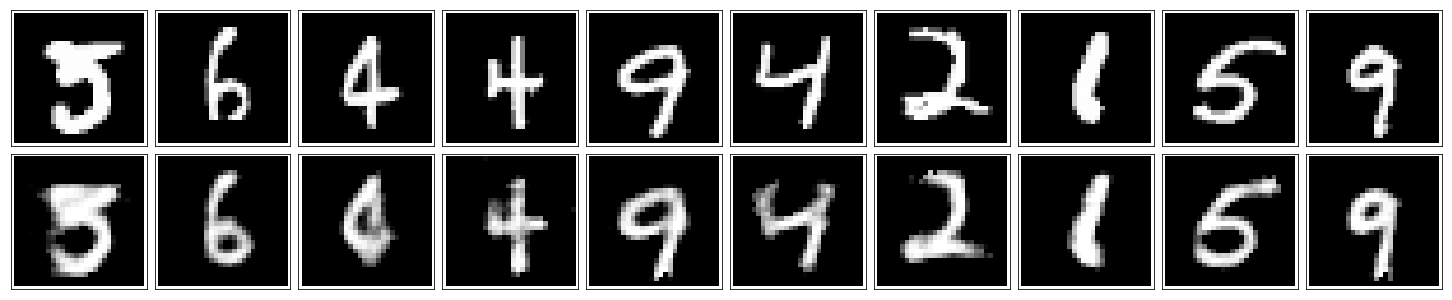

In [8]:
# Check output of autoencoder: print one input/output pairs
in_imgs = []
out_imgs = []
numprint = 10
for i,(img,label) in enumerate(test_set):
    if i >= numprint:
        break
    out_img = decoder20(encoder20(Variable(img)))
    in_imgs += [img[0][0].numpy()] # img is 1x1x28x28 tensor
    out_img.data.clamp_(0, 1)
    out_imgs += [out_img.data.numpy()]

fig = plot_images(in_imgs,out_imgs)

## Visualize denoising performance

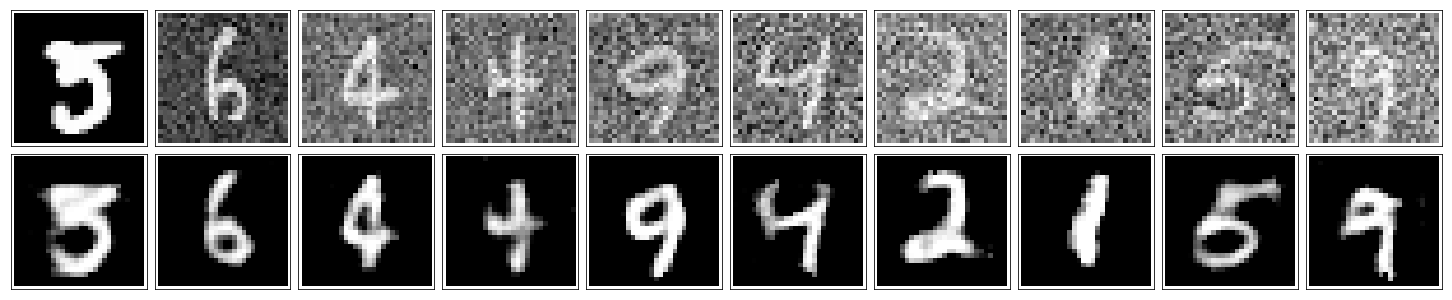

In [9]:
Sigmas = [0.3*i for i in range(10)] # noise variances
noisy_imgs = []
rec_imgs = []
for (img,label),sigma in zip(test_set[:len(Sigmas)],Sigmas):
    img = img[0][0]
    noise = np.sqrt(sigma)*torch.norm(img)/np.sqrt(28*28)*torch.randn(28, 28)
    noisy_img = img + noise
    rec_img = decoder20(encoder20(Variable(noisy_img)))
    rec_img.data.clamp_(0, 1)
    noisy_imgs += [noisy_img.numpy()]
    rec_imgs += [rec_img.data.numpy()]

# plot and save to file
fig = plot_images(noisy_imgs,rec_imgs)
fig.savefig("denoising_ex_0_autoencoder.1.png")

## Generate plots for paper

In [10]:
N = 782
def estimate_MSE(decoder,encoder,dataset,Sigmas,numit=1):
    MSEs = np.zeros(len(Sigmas))
    for i,sigma in enumerate(Sigmas):
        for (img,label) in test_twos[:numit]:
            img = img[0]
            noise = np.sqrt(sigma)*torch.norm(img)/np.sqrt(N)*torch.randn(1, 28, 28)
            noisy_img = img + noise
            rec_img = decoder(encoder(Variable(noisy_img)))
            rec_img.data.clamp_(0, 1)
            MSErec = torch.norm( rec_img.data - img[0] )**2 / torch.norm(img)**2
            MSEs[i] += MSErec/numit
    return MSEs

numit=500
Sigmas = [0.3*i for i in range(22)] # noise variances

MSEs20 = estimate_MSE(decoder20,encoder20,test_set,Sigmas,numit)
MSEs40 = estimate_MSE(decoder40,encoder40,test_set,Sigmas,numit)

Slope of MSE20: 0.04837383098156033
Slope of MSE40: 0.05261360425727614


/Users/reinhardheckel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/Users/reinhardheckel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


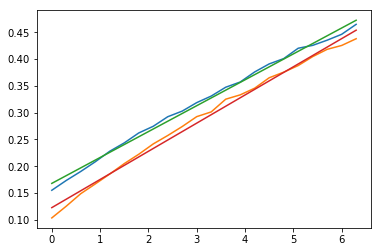

In [13]:
# least squares fit
a,b = np.linalg.lstsq(np.vstack([Sigmas, np.ones(len(Sigmas))]).T,MSEs20)[0]
print("Slope of MSE20:", a)
MSEs20fit = b + np.array(Sigmas)*a

# least squares fit
a,b = np.linalg.lstsq(np.vstack([Sigmas, np.ones(len(Sigmas))]).T,MSEs40)[0]
print("Slope of MSE40:", a)
MSEs40fit = b + np.array(Sigmas)*a


plt.plot(Sigmas,MSEs20)
plt.plot(Sigmas,MSEs40)

plt.plot(Sigmas,MSEs20fit)
plt.plot(Sigmas,MSEs40fit)
plt.show()

mtx = np.array([Sigmas, MSEs20, MSEs40, MSEs20fit, MSEs40fit])
np.savetxt("./denoise_learned_hourglass.dat", mtx.T , delimiter='\t')